<p> <img src="https://simapro.com/wp-content/uploads/2018/04/ecoinvent_logo_2016-280x280.png" alt="ecoinvent" align="right">
</p>

<h1>
<p style ="font-family:Helvetica;color:#DE3B31;font-size:25pt"> Ecoinvent Inverview Coding Challenge </p>
</h1>

<h4>
<p style="font-size:16pt;font-family:Helvetica;color:#353638"> Matej Puchovsky</p>
<p style="font-size:14pt;font-family:Helvetica;color:#353638">07 November 2018</p>
</h4>

# Importing the preamble

In [12]:
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import glob, os
%matplotlib inline
make_float = lambda x: "{:.2e}".format(x)
pd.set_option('display.float_format', '{:.2e}'.format)
ET.register_namespace("","http://www.EcoInvent.org/EcoSpold02")

# Defining the final function for data preparation and visualisation

In [ ]:
def create_visualisation(root):  

    # Find the name of the analysed activity/process:
    for name in root.iter('{http://www.EcoInvent.org/EcoSpold02}activityName'):
        activity_name = name.text

    # Find the geography of the analysed activity/process:
    for geo in root.iter('{http://www.EcoInvent.org/EcoSpold02}geography'):
        geo_name = geo.find('{http://www.EcoInvent.org/EcoSpold02}shortname').text

    # Save the data about activity name & geography in a table (pandas):    
    cols = ['activity_name', 'geography']
    activ = pd.DataFrame(columns=cols)
    activ = activ.append(pd.Series([activity_name, geo_name], index=cols),ignore_index=True)
    
    # Wrap the text in the "activity_name"-field, in order for it to fit in the final visualisation:
    activ["activity_name"] = activ["activity_name"].str.wrap(50)
# ----------------------------------------------------------------------------------------- #
    
# Prepare table for exchange-data:
    dfcols = ['name', 'amount', 'unitname', 'input', 'natural_resource',
              'technosphere','emissions', 'product', 'waste']
    df_xml = pd.DataFrame(columns=dfcols)

    # Iterate over all elementary exchanges:
    for elementary in root.iter('{http://www.EcoInvent.org/EcoSpold02}elementaryExchange'):
        # Extract exchange name:
        name = elementary.find('{http://www.EcoInvent.org/EcoSpold02}name').text
        # Extract units:
        unitname = elementary.find('{http://www.EcoInvent.org/EcoSpold02}unitName').text
        # Extract exchange attribute "output/input amount":
        amount = float(elementary.get('amount'))
        
        # Find out, whether the element is an input or an output and what kind of input/output it is:
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') is not None):
            input_ = 1
        else:
            input_ = 0
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') == "4"):
            natural_resource  = 1
        else:
            natural_resource  = 0
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') == "5"):
            technosphere  = 1
        else:
            technosphere  = 0
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "4"):
            emissions = 1
        else:
            emissions = 0
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "0"):
            product = 1
        else:
            product = 0
        if (elementary.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "2"):
            waste = 1 
        else:
            waste = 0 
            
        # Populate prepared pandas-table:
        df_xml = df_xml.append(pd.Series([name,amount,unitname,input_,natural_resource,technosphere,
              emissions,product,waste], index=dfcols),ignore_index=True)
    
    # Repeat previous iteration with intermediate exchanges:
    for exchange in root.iter('{http://www.EcoInvent.org/EcoSpold02}intermediateExchange'):
        name = exchange.find('{http://www.EcoInvent.org/EcoSpold02}name').text
        unitname = exchange.find('{http://www.EcoInvent.org/EcoSpold02}unitName').text
        amount = float(exchange.get('amount'))
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') is not None):
            input_ = 1
        else:
            input_ = 0
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') == "4"):
            natural_resource  = 1
        else:
            natural_resource  = 0
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}inputGroup') == "5"):
            technosphere  = 1
        else:
            technosphere  = 0
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "4"):
            emissions = 1
        else:
            emissions = 0
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "0"):
            product = 1
        else:
            product = 0
        if (exchange.findtext('{http://www.EcoInvent.org/EcoSpold02}outputGroup') == "2"):
            waste = 1 
        else:
            waste = 0 
        df_xml = df_xml.append(pd.Series([name,amount,unitname,input_,natural_resource,technosphere,
              emissions,product,waste], index=dfcols),ignore_index=True)

    # Group exchanges with same name per group & sum the amounts:    
    df_xml = df_xml.groupby(['name', 'unitname', 'input', 'natural_resource',
                    'technosphere','emissions', 'product', 'waste']).agg({'amount':'sum'}).reset_index()
# ----------------------------------------------------------------------------------------- #
    
# Prepare data for final visualisation
    # Round amounts to four decimal places if the value is big enough, use scientific notation if otherwhise:
    for i in df_xml:
        subset = df_xml[df_xml['amount'] > 0.00005]
        # Create "text"-column with all the information needed for the final visualisation:
        df_xml['text'] = round((subset['amount']),4).astype(str) + ' ' + subset['unitname'] + ' of ' + subset['name']

    df_xml['text'].fillna((df_xml['amount'].apply(make_float).astype(str) + ' ' + df_xml['unitname'] \
                           + ' of ' + df_xml['name']), inplace=True)
    
    # Wrap "text"-column fields to make it fit into the visualisation:
    df_xml['text'] = df_xml['text'].str.wrap(20)

    # Prepare separate tables for all groups of exchanges with top five exchanges by amount (four for waster):
    technosphere = df_xml[df_xml.technosphere == 1].sort_values(by="amount", ascending = False).head(5)
    natural_resource = df_xml[df_xml.natural_resource == 1].sort_values(by="amount", ascending = False).head(5)
    emissions = df_xml[df_xml.emissions == 1].sort_values(by="amount", ascending = False).head(5)
    product = df_xml[df_xml['product'] == 1]
    waste = df_xml[df_xml.waste == 1].sort_values(by="amount", ascending = False).head(4)
# ----------------------------------------------------------------------------------------- #
    
# Create final visualisation
    # Set dimensions & axes' limits of the figure (+ intersection points in the middle)
    fig_width = 20 
    fig_height = 10

    fig_width_mid = fig_width / 2
    fig_height_mid = fig_height / 2

    fig1 = plt.figure(figsize=(fig_width,fig_height))

    # Set dimensions of the rectangle describing the plant/process:
    rec_width = 8
    rec_height = 2

    # Set location (i.e. starting coordinates) of the rectangle describing the plant/process:
    start_rect_x = (fig_width-rec_width)/2
    start_rect_y = (fig_height-rec_height)/2

    # Base coordinates of the technosphere exchanges:
    techno_x = 0.5
    techno_y = fig_height_mid

    # Base coordinates of the natural resource exchanges:
    nat_x = fig_width_mid 
    nat_y = 1
    
    # Base coordinates of emission exchanges:
    em_x = fig_width_mid 
    em_y = 9

    # Base coordinates of waster/byproduct exchanges:
    waste_x = 20 - (rec_width / 2) + 1
    waste_y = fig_height_mid

    # ------------------------------------------------------------------------- #

    # Add rectangle describing the plant/process into the middle of the figure:
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(patches.Rectangle((start_rect_x, start_rect_y), rec_width, rec_height,
                                   facecolor="#e6e6ff", edgecolor="#00004d", linestyle="--"))


    # Add figure title (including the name of the plant/process)
    plt.title("Pollution model for " + activity_name, fontsize=14, weight="bold")

    # Upper & lower bound limits of the figure:
    plt.ylim(0,10)
    plt.xlim(0,20)
    # Hide ticks from both axes:
    plt.xticks([])
    plt.yticks([])

    # Add description of the plant/process and the correspodning geography into the created rectangle:
    for i in range(0,len(activ)):    
        plt.annotate(activ.iloc[i]["activity_name"], xy=(fig_width_mid, fig_height_mid),
                     fontsize=16, ha='center', va='center', color = "black")
        plt.annotate(activ.iloc[i]["geography"], xy=(fig_width_mid, (fig_height_mid-0.7)),
                     fontsize=16, ha='center', va='center', color = "black")

    # Add descriptions of the technosphere inputs & the corresponding arrows pointing
    # towards the centre of the plant-rectangle:
    for i in range(0,len(technosphere)):
        plt.annotate(technosphere.iloc[i]['text'], xy=(techno_x, (techno_y+len(technosphere)/2)), fontsize=11)
        plt.annotate("",
                xy=(start_rect_x, fig_height_mid),
                xytext=(techno_x+2.25, (techno_y+len(technosphere)/2)+0.25),
                arrowprops=dict(arrowstyle="simple, head_width=0.75, head_length=3",color="#996633"))
        techno_y -= 1.5

    # Add descriptions of the natural resource inputs & the corresponding arrows pointing
    # towards the centre of the plant-rectangle:
    for i in range(0,len(natural_resource)):
        plt.annotate(natural_resource.iloc[i]['text'], xy=(nat_x-len(natural_resource), nat_y), fontsize=11)
        plt.annotate("",
                xy=(fig_width_mid, start_rect_y),
                xytext=(nat_x-len(natural_resource)+1, nat_y+0.75),
                arrowprops=dict(arrowstyle="simple, head_width=0.75, head_length=3",color="#336699"))
        nat_x += 2.5

    # Add descriptions of the emissions into environment & the corresponding arrows pointing
    # away from the centre of the plant-rectangle towards the descriptions:
    for i in range(0,len(emissions)):
        plt.annotate(emissions.iloc[i]['text'], xy=((em_x-len(emissions)), em_y), fontsize=11)
        plt.annotate("",
                xy=(em_x-len(emissions)+1, em_y-0.25),
                xytext=(fig_width_mid, start_rect_y + rec_height),
                arrowprops=dict(arrowstyle="simple, head_width=0.75, head_length=3",color="0.5"))
        em_x += 2.5

    # Add description of the reference product & the corresponding arrows pointing
    # away from the centre of the plant-rectangle towards the product description:
    for i in range(0,len(product)):
        plt.annotate(product.iloc[i]['text'], xy=(waste_x, waste_y+(len(waste)/2)), fontsize=11)
        plt.annotate("",
                xy=(waste_x-0.25,  waste_y+(len(waste)/2)+0.25),
                xytext=(start_rect_x + rec_width, fig_height_mid),
                arrowprops=dict(arrowstyle="simple, head_width=0.75, head_length=3",color="#006600"))
        waste_y -= 1.25
 
    # Add description of the waste/byproducts & the corresponding arrows pointing
    # away from the centre of the plant-rectangle towards the waster/byproduct descriptions:
    for i in range(0,len(waste)):
        plt.annotate(waste.iloc[i]['text'], xy=(waste_x, waste_y+(len(waste)/2)), fontsize=11)
        plt.annotate("",
                xy=(waste_x-0.25,  waste_y+(len(waste)/2)+0.25),
                xytext=(start_rect_x + rec_width, fig_height_mid),
                arrowprops=dict(arrowstyle="simple, head_width=0.75, head_length=3",color="#f9a21f"))
        waste_y -= 1.25

    # Add legend of exchange types to the visualisation:
    legend_elements = [Line2D([0], [0], color='#996633', lw=4, label='technosphere input'),
                       Line2D([0], [0], color='#336699', lw=4, label='natural resource input'),
                       Line2D([0], [0], color='0.5', lw=4, label='emission'),
                       Line2D([0], [0], color='#006600', lw=4, label='reference product'),
                       Line2D([0], [0], color='#f9a21f', lw=4, label='waste/byproduct')
                   ]
   
    # Add legend title & define fixed position (lower centre with five columns with no frame):
    plt.annotate("Exchange types: ", xy=(1.5,0.23), fontsize=11, style="italic")
    plt.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=11, frameon=False)
    
    # Add file name to the name of visualisation & save it in the folder:
    plt.savefig('%s.png' % (file), dpi=300)

# Iterating defined function over all files in the source directory

46670f16-8da0-4bbf-a84c-9f1e3023c8f3.spold
1e187606-e5a7-4526-b652-e519e51b07a6.spold
1fd7de1f-f934-46ae-8d18-3a85502e8a95.spold
1cf3e001-005f-4f4e-8ee7-57fde7055b80.spold
6598953b-c375-531b-9c7f-5572cc9d2ea7.spold
025a593a-f891-4750-8f58-1d47fd209d7c.spold
5a4129c9-1ae7-4e8d-a7c2-1016a5814161.spold
1de9b8e0-22ad-44c9-8484-54aa57ce3dd7.spold
77a16b81-395c-4ffc-bd0b-a9cc07a008a8.spold
6de99777-363f-43b0-83cb-0e34485dcacc.spold


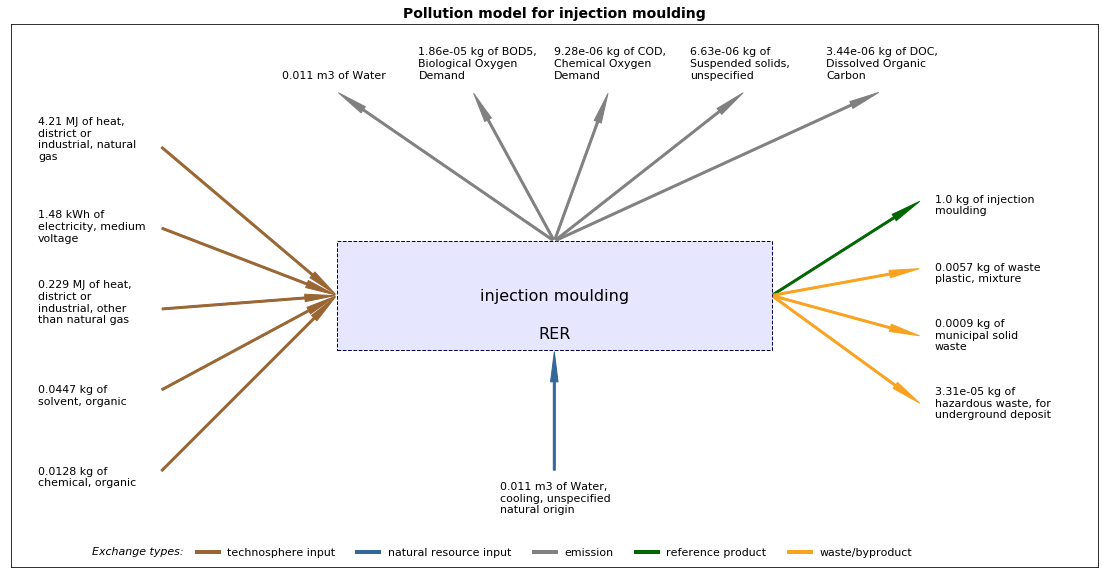

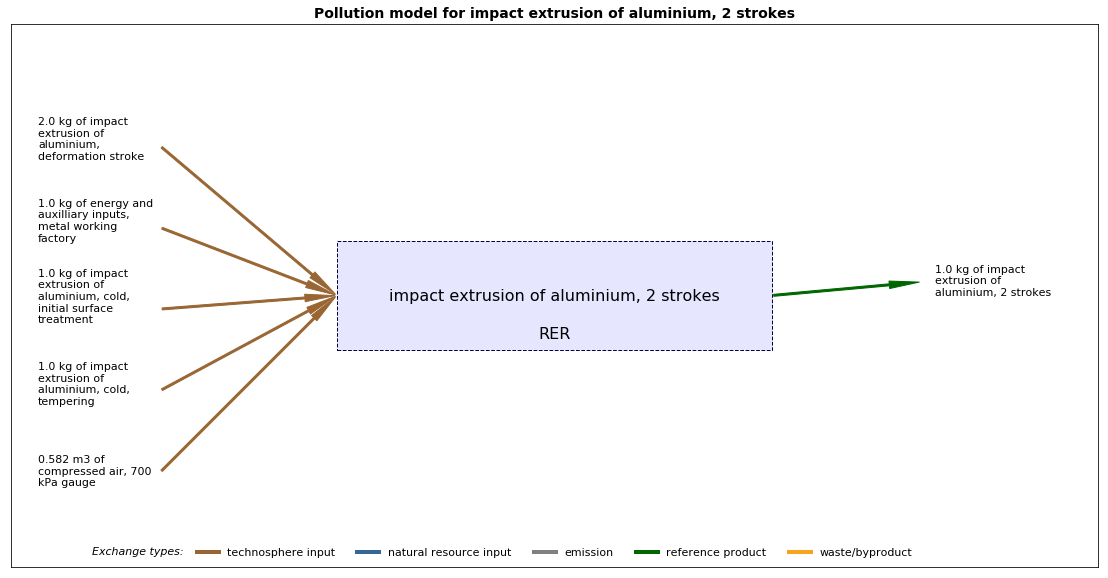

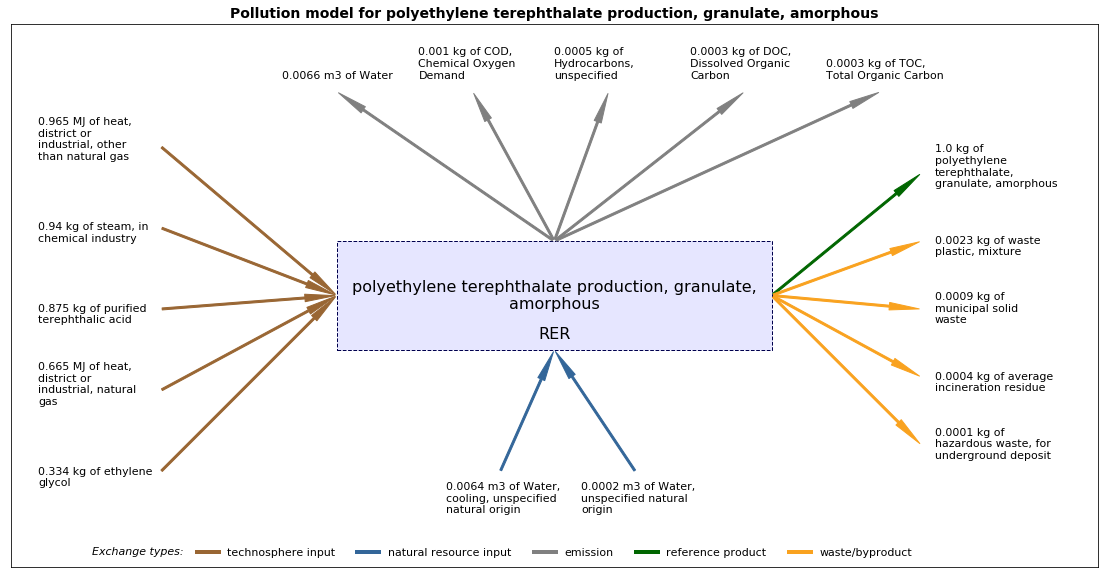

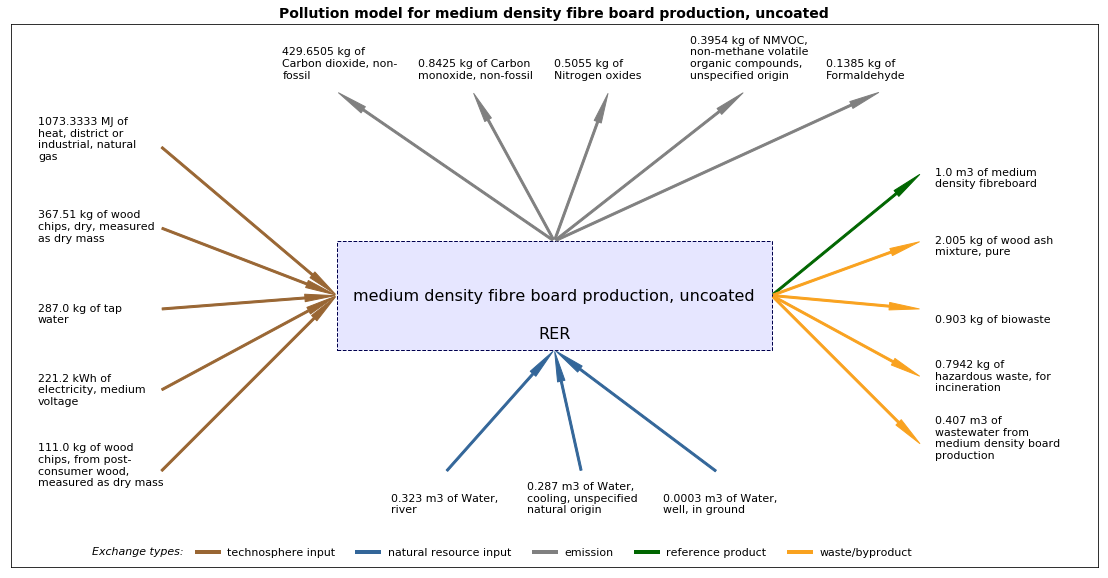

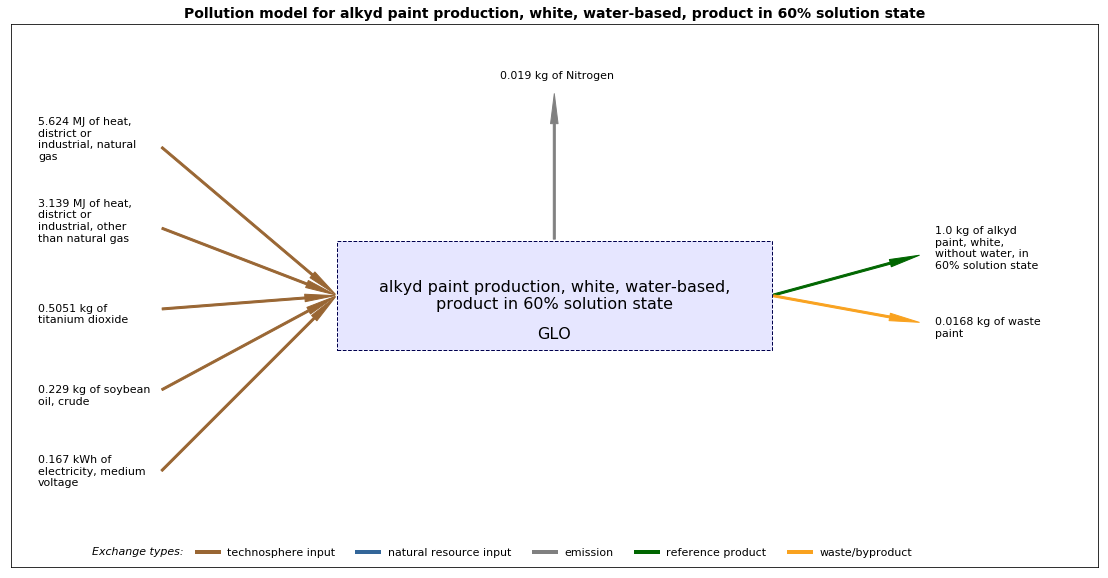

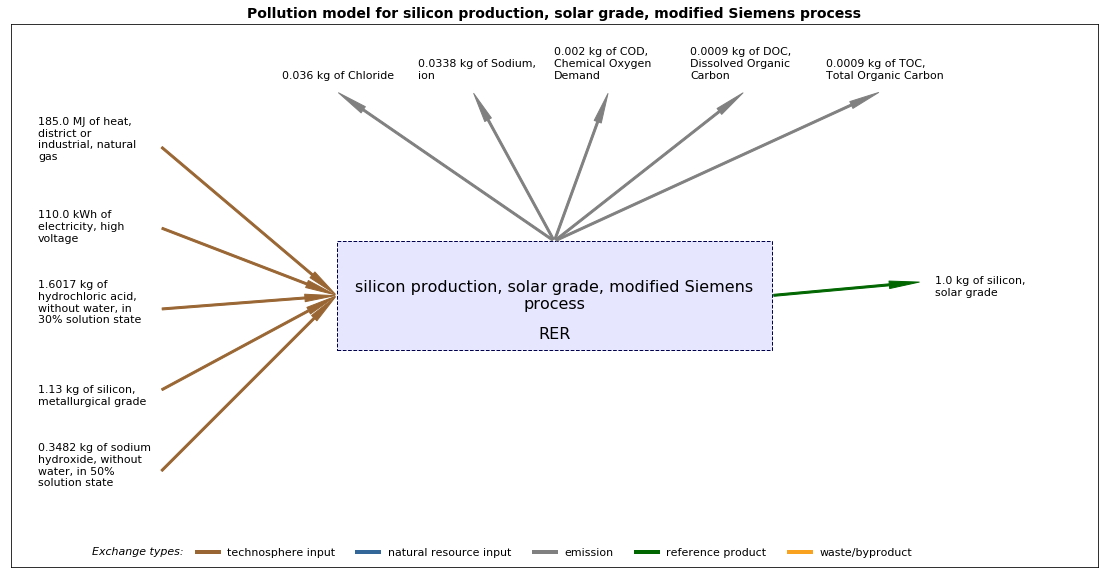

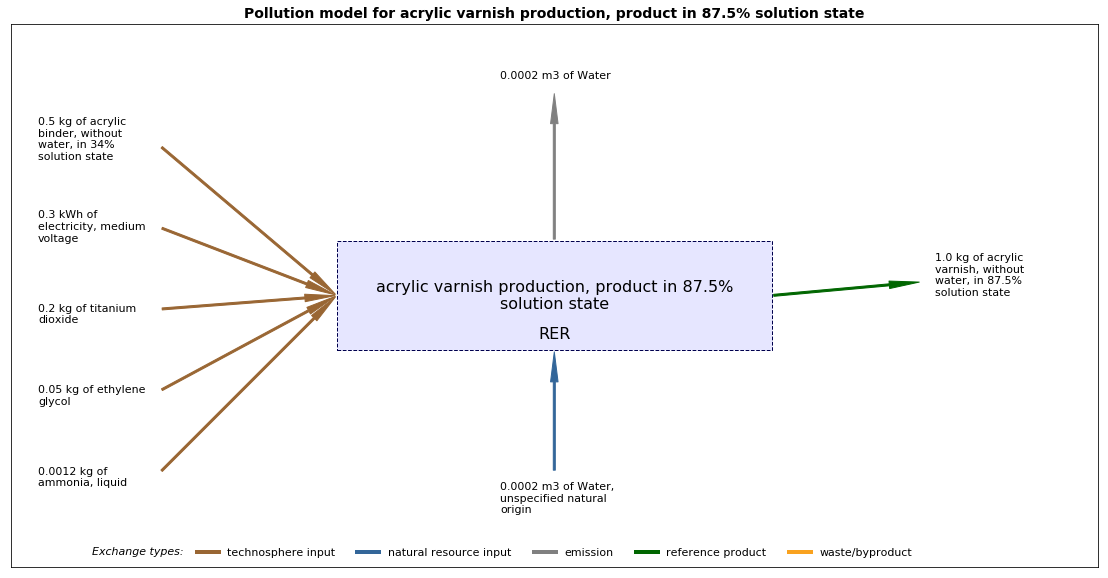

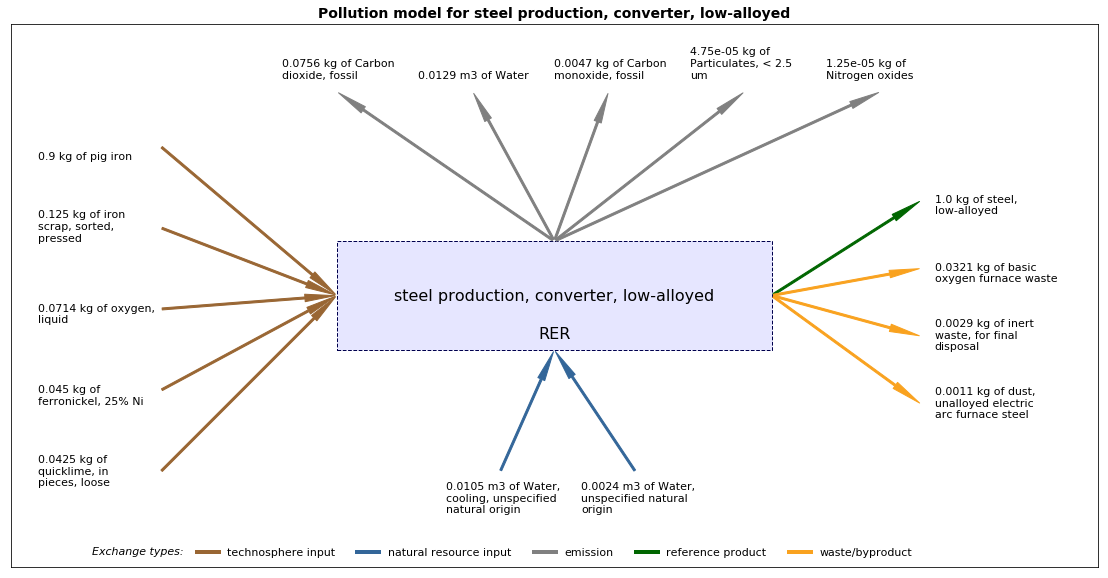

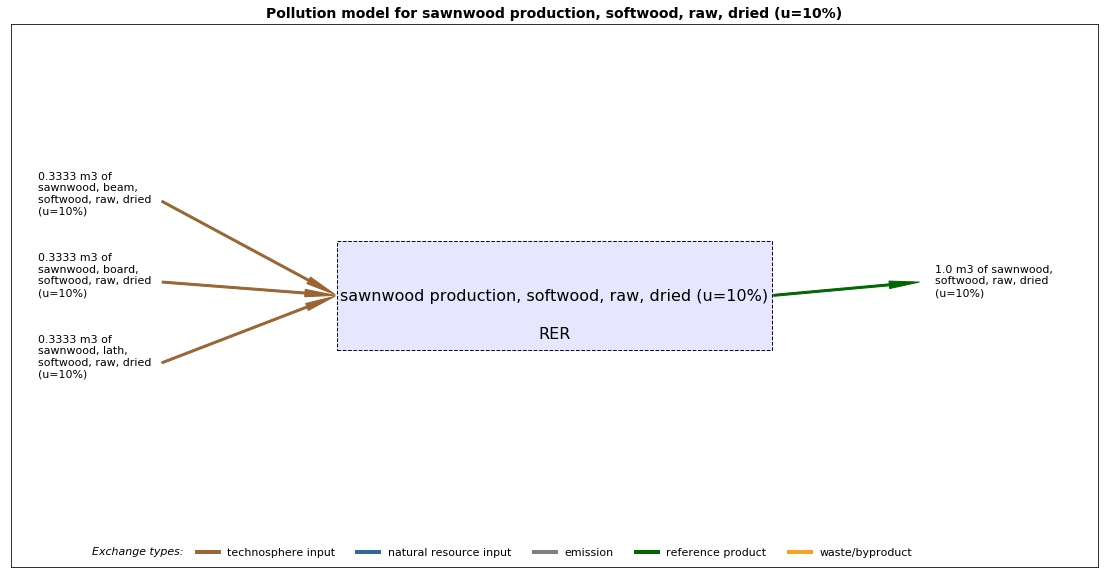

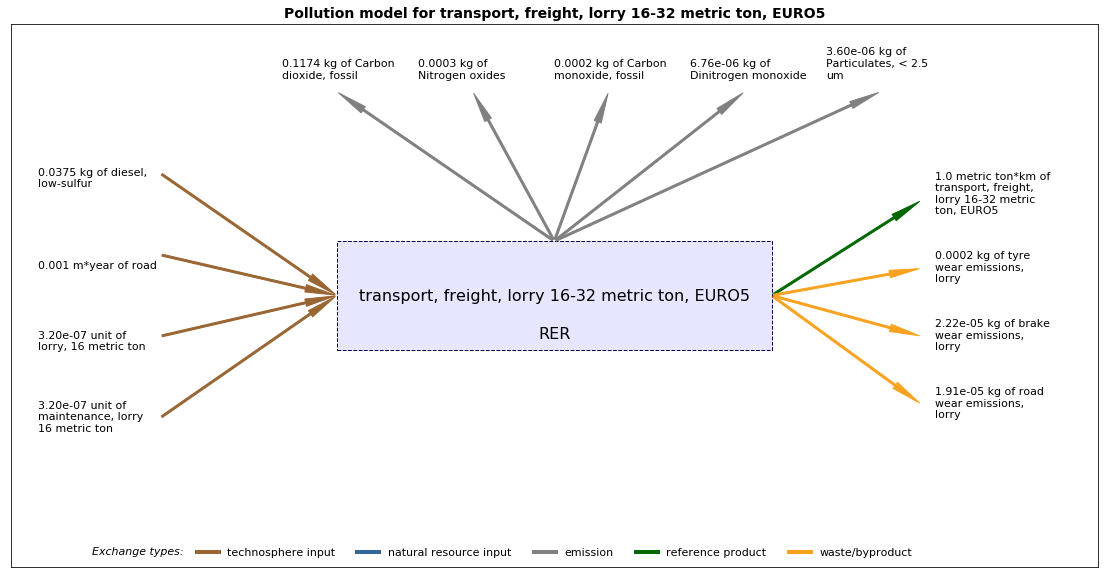

In [14]:
os.chdir("/Users/matej/Desktop/Career/Firmen/Offen/ecoinvent/datasets")
# Iterate over all spold files in the folder:
for file in glob.glob("*.spold"):
    # List the name of all files that are to be processed:
    print(file)
    # Parse the XML section of the imported file into an element tree
    document = ET.parse(file)
    # Return the root element for the imported tree
    root = document.getroot()
    # Call function to process data & create visualisation
    create_visualisation(root)